This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [4]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-11-29 14:19:59--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.52.104, 52.217.91.200, 52.216.248.206, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.52.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  13.7MB/s    in 0.9s    

2022-11-29 14:20:00 (13.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [5]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [6]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

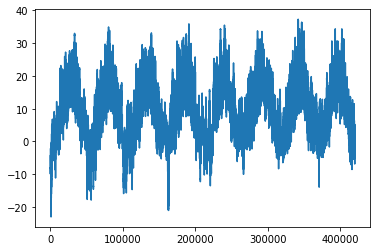

In [7]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

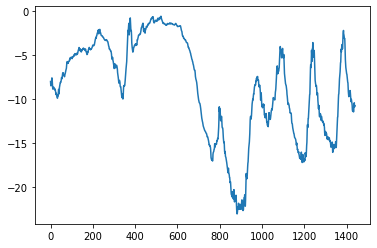

In [8]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [10]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [11]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [12]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [13]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [14]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 41s 47ms/step - loss: 16.1817 - mae: 3.1194 - val_loss: 12.8608 - val_mae: 2.8456
Epoch 2/10
819/819 [==============================] - 39s 47ms/step - loss: 11.3434 - mae: 2.6548 - val_loss: 11.1502 - val_mae: 2.6352
Epoch 3/10
819/819 [==============================] - 39s 47ms/step - loss: 10.4491 - mae: 2.5445 - val_loss: 11.1291 - val_mae: 2.6384
Epoch 4/10
819/819 [==============================] - 39s 47ms/step - loss: 9.8820 - mae: 2.4695 - val_loss: 13.0739 - val_mae: 2.8813
Epoch 5/10
819/819 [==============================] - 39s 47ms/step - loss: 9.3984 - mae: 2.4060 - val_loss: 12.6555 - val_mae: 2.8034
Epoch 6/10
819/819 [==============================] - 39s 47ms/step - loss: 8.9711 - mae: 2.3522 - val_loss: 10.8607 - val_mae: 2.6062
Epoch 7/10
819/819 [==============================] - 40s 49ms/step - loss: 8.6545 - mae: 2.3123 - val_loss: 10.6108 - val_mae: 2.5640
Epoch 8/10
819/819 [==============================] 

**Plotting results**

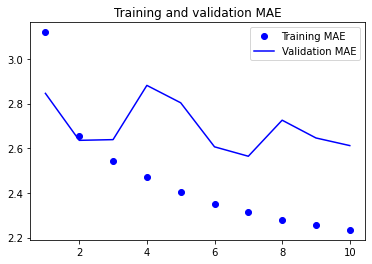

In [16]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 46s 49ms/step - loss: 22.0308 - mae: 3.6774 - val_loss: 16.9894 - val_mae: 3.2418
Epoch 2/10
819/819 [==============================] - 40s 48ms/step - loss: 14.9477 - mae: 3.0620 - val_loss: 14.7053 - val_mae: 3.0407
Epoch 3/10
819/819 [==============================] - 40s 48ms/step - loss: 13.5555 - mae: 2.9127 - val_loss: 14.5806 - val_mae: 3.0213
Epoch 4/10
819/819 [==============================] - 40s 48ms/step - loss: 12.6199 - mae: 2.8063 - val_loss: 14.5609 - val_mae: 3.0020
Epoch 5/10
819/819 [==============================] - 40s 48ms/step - loss: 11.9313 - mae: 2.7239 - val_loss: 14.1906 - val_mae: 2.9507
Epoch 6/10
819/819 [==============================] - 41s 50ms/step - loss: 11.3769 - mae: 2.6585 - val_loss: 14.9940 - val_mae: 3.0671
Epoch 7/10
819/819 [==============================] - 40s 48ms/step - loss: 10.9043 - mae: 2.6032 - val_loss: 13.9127 - val_mae: 2.9424
Epoch 8/10
819/819 [============================

### A first recurrent baseline

**A simple LSTM-based model**

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 46s 52ms/step - loss: 40.2359 - mae: 4.6122 - val_loss: 12.0472 - val_mae: 2.6474
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 10.9761 - mae: 2.5684 - val_loss: 9.4062 - val_mae: 2.3820
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 9.7449 - mae: 2.4342 - val_loss: 9.3845 - val_mae: 2.3717
Epoch 4/10
819/819 [==============================] - 43s 52ms/step - loss: 9.3919 - mae: 2.3884 - val_loss: 9.6136 - val_mae: 2.3826
Epoch 5/10
819/819 [==============================] - 45s 54ms/step - loss: 9.1431 - mae: 2.3544 - val_loss: 9.6631 - val_mae: 2.3945
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 8.9003 - mae: 2.3184 - val_loss: 10.0819 - val_mae: 2.4428
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 8.6799 - mae: 2.2895 - val_loss: 9.8260 - val_mae: 2.4301
Epoch 8/10
819/819 [==============================] - 43s 

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [19]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [20]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [21]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [22]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [23]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/20
819/819 [==============================] - 336s 407ms/step - loss: 29.7011 - mae: 4.0014 - val_loss: 9.8069 - val_mae: 2.4354
Epoch 2/20
819/819 [==============================] - 335s 408ms/step - loss: 14.9730 - mae: 3.0047 - val_loss: 10.0043 - val_mae: 2.4590
Epoch 3/20
819/819 [==============================] - 334s 407ms/step - loss: 14.1709 - mae: 2.9170 - val_loss: 9.6439 - val_mae: 2.4190
Epoch 4/20
819/819 [==============================] - 337s 411ms/step - loss: 13.6060 - mae: 2.8542 - val_loss: 9.5379 - val_mae: 2.4018
Epoch 5/20
819/819 [==============================] - 334s 408ms/step - loss: 13.2361 - mae: 2.8118 - val_loss: 9.4893 - val_mae: 2.3910
Epoch 6/20
819/819 [==============================] - 336s 410ms/step - loss: 12.8217 - mae: 2.7704 - val_loss: 9.6672 - val_mae: 2.4153
Epoch 7/20
819/819 [==============================] - 334s 408ms/step - loss: 12.4133 - mae: 2.7268 - val_loss: 9.6661 - val_mae: 2.4168
Epoch 8/20
819/819 [====================

In [25]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=1,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

819/819 [==============================] - 617s 748ms/step - loss: 26.0281 - mae: 3.7557 - val_loss: 9.4358 - val_mae: 2.3682


405/405 [==============================] - 38s 92ms/step - loss: 11.2224 - mae: 2.5960
Test MAE: 2.60


### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [28]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 51s 59ms/step - loss: 25.5473 - mae: 3.6254 - val_loss: 10.3258 - val_mae: 2.4860
Epoch 2/10
819/819 [==============================] - 47s 58ms/step - loss: 9.5197 - mae: 2.4050 - val_loss: 10.0306 - val_mae: 2.4425
Epoch 3/10
819/819 [==============================] - 48s 58ms/step - loss: 8.6105 - mae: 2.2840 - val_loss: 10.3595 - val_mae: 2.4896
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 8.0080 - mae: 2.2076 - val_loss: 10.2994 - val_mae: 2.4777
Epoch 5/10
819/819 [==============================] - 47s 57ms/step - loss: 7.5739 - mae: 2.1498 - val_loss: 10.3308 - val_mae: 2.4932
Epoch 6/10
819/819 [==============================] - 47s 57ms/step - loss: 7.2471 - mae: 2.1083 - val_loss: 10.3973 - val_mae: 2.4977
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 6.9649 - mae: 2.0680 - val_loss: 10.8156 - val_mae: 2.5542
Epoch 8/10
819/819 [==============================] - 

### Going even further

## Summary